<a href="https://colab.research.google.com/github/Samir-Doghmi/Deep_Learning/blob/main/4_CNN_Resnet_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Normalization, Dense
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
import os
from pathlib import Path
import PIL
from PIL import Image
import statistics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# seed initialization to get same results
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

# Upload

In [ ]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import file in the virtual machine
t0 = time()
# Transfer zip dataset to the current virtual machine
copyfile('/content/gdrive/MyDrive/Project_DeepLearning/flower_photos_divided.zip', 'flower_photos_divided.zip') # fonte e dove copiarlo
# Extract files
zip = zipfile.ZipFile('flower_photos_divided.zip') #scompatta cartella zippata
zip.extractall() #invochiamo zip
zip.close() # necessario per accellerare le operazioni
print("File transfer completed in %0.3f seconds" % (time() - t0))

base_path = Path('flower_photos/')

File transfer completed in 5.958 seconds


# Data



## Train and Validation

In [ ]:
# train dataset

train_dataset = keras.preprocessing.image_dataset_from_directory("flower_photos_divided/train",
                                                            image_size=(224,224), #dimesione standard
                                                            batch_size=64,
                                                            label_mode='categorical',
                                                            #subset='training',
                                                            #validation_split = 0.2,
                                                            shuffle=True,# Data shuffling
                                                            seed=1)


Found 2935 files belonging to 5 classes.


In [ ]:
class_names = train_dataset.class_names
classes = list(range(len(class_names)))
labels = class_names

print("Classes:", classes)
print("Labels:", labels)

Classes: [0, 1, 2, 3, 4]
Labels: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
# validation dataset
val_dataset = keras.preprocessing.image_dataset_from_directory("flower_photos_divided/test",
                                                            image_size=(224,224), #dimesione standard
                                                            batch_size=64,
                                                            label_mode='categorical',
                                                           #subset='validation',
                                                            #validation_split = 0.2,
                                                            shuffle=False,
                                                            seed=1)


Found 735 files belonging to 5 classes.


### Visualize the data

## Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal_and_vertical"),
     layers.RandomRotation(0.4),
     layers.RandomBrightness(factor= 0.4), # allowing the generator to randomly darken the image of 0.2 or 20%
     layers.RandomZoom(0.2),
     layers.RandomCrop(180,260),
     layers.Resizing(224,224),
     layers.Normalization()
    ]
)

In [ ]:
num_classes = 5

In [ ]:
# we set an early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#we save only the best model
checkpoint_filepath = '/content/gdrive/MyDrive/Project_DeepLearning/ modelli resnet/Model_ResNet50_2_2(128 batch)'
mcp_save = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')



# *ResNet50*

ResNet50 is residual network architecture with 103 layers and composed of  25.6M Millions parameters. The normalization and ReLU activation are applied before each convolutional layer.

In [ ]:
#using  ResNet50
from tensorflow.keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

In [ ]:
# we set an early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

#we save only the best model
checkpoint_filepath = 'gdrive/MyDrive/Project_DeepLearning/Model_InceptionResNetV2_model_2_2 (32 batch)'
mcp_save1 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [ ]:
ResNet50_model = tf.keras.applications.ResNet50(
    include_top=True,
    weights='imagenet',
    classifier_activation='softmax', #This parameter determines the activation function used in the output layer (classifier)
    input_tensor=tf.keras.layers.Input(shape=(224,224,3)))





We print the summary of the model

In [ ]:
print(ResNet50_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
 # We freeze the weights of a pre-trained model.Freezing the pre-trained model's weights helps to preserve the already learned features and prevents them from being overwritten or altered during training.
ResNet50_model.trainable = False
 #If you have a small dataset, freezing the weights of the pre-trained model and using it as a feature extractor can be beneficial.

In [ ]:
#Unfreezing the BatchNormalization layers allows these parameters to be updated during the fine-tuning process, adapting the normalization to the new dataset.
#By unfreezing the BatchNormalization layers, you enable the model to adjust the normalization statistics specifically for the new dataset, which can help improve the model's performance and adaptability.
for layer in ResNet50_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [ ]:
# Get the last layer of the model
last_layer = ResNet50_model.layers[-1]

# Modify the last layer to have the desired number of units (ne aveva 1000)
new_last_layer = Dense(num_classes, activation='softmax')(last_layer.output)

# Create a new model with the modified last layer
ResNet50_model= Model(inputs=ResNet50_model.input, outputs=new_last_layer)

In [ ]:
# Explicit input layer
inputs = keras.Input((224,224,3))
# we apply data augmetation
x = data_augmentation(inputs)

# Image preprocessing for consistency with the pretrained model x = keras.applications.mobilenet_v2.preprocess_input(x)
# Output of the base model
x = ResNet50_model(x)

# New intermediate fully-connected layer + ReLU
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# New (final) fully-connected layer + SoftMax activation
x = tf.keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

In [ ]:
# Compile the model for training
ResNet50_model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
# Model training
history1 = ResNet50_model.fit(train_dataset,
          epochs=100,
          validation_data=val_dataset,
          callbacks=[callback, mcp_save1]);

Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 1.6042 - accuracy: 0.3080

23/23 [==============================] - 89s 2s/step - loss: 1.6042 - accuracy: 0.3080 - val_loss: 1.5961 - val_accuracy: 0.3524
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 1.5954 - accuracy: 0.3537

23/23 [==============================] - 47s 2s/step - loss: 1.5954 - accuracy: 0.3537 - val_loss: 1.5851 - val_accuracy: 0.3660
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 1.5867 - accuracy: 0.3779

23/23 [==============================] - 49s 2s/step - loss: 1.5867 - accuracy: 0.3779 - val_loss: 1.5729 - val_accuracy: 0.4626
Epoch 4/100
23/23 [==============================] - ETA: 0s - loss: 1.5765 - accuracy: 0.3908

23/23 [==============================] - 48s 2s/step - loss: 1.5765 - accuracy: 0.3908 - val_loss: 1.5596 - val_accuracy: 0.4952
Epoch 5/100
23/23 [==============================] - ETA: 0s - loss: 1.5651 - accuracy: 0.4276

23/23 [==============================] - 47s 2s/step - loss: 1.5651 - accuracy: 0.4276 - val_loss: 1.5454 - val_accuracy: 0.5197
Epoch 6/100
23/23 [==============================] - ETA: 0s - loss: 1.5517 - accuracy: 0.4528

23/23 [==============================] - 48s 2s/step - loss: 1.5517 - accuracy: 0.4528 - val_loss: 1.5300 - val_accuracy: 0.5429
Epoch 7/100
23/23 [==============================] - ETA: 0s - loss: 1.5366 - accuracy: 0.4712

23/23 [==============================] - 48s 2s/step - loss: 1.5366 - accuracy: 0.4712 - val_loss: 1.5126 - val_accuracy: 0.5633
Epoch 8/100
23/23 [==============================] - ETA: 0s - loss: 1.5197 - accuracy: 0.5026

23/23 [==============================] - 47s 2s/step - loss: 1.5197 - accuracy: 0.5026 - val_loss: 1.4938 - val_accuracy: 0.5823
Epoch 9/100
23/23 [==============================] - ETA: 0s - loss: 1.4996 - accuracy: 0.5278

23/23 [==============================] - 49s 2s/step - loss: 1.4996 - accuracy: 0.5278 - val_loss: 1.4724 - val_accuracy: 0.6041
Epoch 10/100
23/23 [==============================] - ETA: 0s - loss: 1.4780 - accuracy: 0.5503

23/23 [==============================] - 47s 2s/step - loss: 1.4780 - accuracy: 0.5503 - val_loss: 1.4492 - val_accuracy: 0.6299
Epoch 11/100
23/23 [==============================] - ETA: 0s - loss: 1.4537 - accuracy: 0.5809

23/23 [==============================] - 49s 2s/step - loss: 1.4537 - accuracy: 0.5809 - val_loss: 1.4237 - val_accuracy: 0.6463
Epoch 12/100
23/23 [==============================] - ETA: 0s - loss: 1.4279 - accuracy: 0.6106

23/23 [==============================] - 47s 2s/step - loss: 1.4279 - accuracy: 0.6106 - val_loss: 1.3977 - val_accuracy: 0.6639
Epoch 13/100
23/23 [==============================] - ETA: 0s - loss: 1.4019 - accuracy: 0.6365

23/23 [==============================] - 50s 2s/step - loss: 1.4019 - accuracy: 0.6365 - val_loss: 1.3719 - val_accuracy: 0.6830
Epoch 14/100
23/23 [==============================] - ETA: 0s - loss: 1.3737 - accuracy: 0.6681

23/23 [==============================] - 49s 2s/step - loss: 1.3737 - accuracy: 0.6681 - val_loss: 1.3462 - val_accuracy: 0.7034
Epoch 15/100
23/23 [==============================] - ETA: 0s - loss: 1.3438 - accuracy: 0.7049

23/23 [==============================] - 49s 2s/step - loss: 1.3438 - accuracy: 0.7049 - val_loss: 1.3200 - val_accuracy: 0.7238
Epoch 16/100
23/23 [==============================] - ETA: 0s - loss: 1.3142 - accuracy: 0.7363

23/23 [==============================] - 47s 2s/step - loss: 1.3142 - accuracy: 0.7363 - val_loss: 1.2935 - val_accuracy: 0.7333
Epoch 17/100
23/23 [==============================] - ETA: 0s - loss: 1.2825 - accuracy: 0.7588

23/23 [==============================] - 49s 2s/step - loss: 1.2825 - accuracy: 0.7588 - val_loss: 1.2674 - val_accuracy: 0.7605
Epoch 18/100
23/23 [==============================] - ETA: 0s - loss: 1.2508 - accuracy: 0.7830

23/23 [==============================] - 48s 2s/step - loss: 1.2508 - accuracy: 0.7830 - val_loss: 1.2404 - val_accuracy: 0.7633
Epoch 19/100
23/23 [==============================] - ETA: 0s - loss: 1.2192 - accuracy: 0.8024

23/23 [==============================] - 48s 2s/step - loss: 1.2192 - accuracy: 0.8024 - val_loss: 1.2130 - val_accuracy: 0.7646
Epoch 20/100
23/23 [==============================] - ETA: 0s - loss: 1.1858 - accuracy: 0.8184

23/23 [==============================] - 50s 2s/step - loss: 1.1858 - accuracy: 0.8184 - val_loss: 1.1857 - val_accuracy: 0.7728
Epoch 21/100
23/23 [==============================] - ETA: 0s - loss: 1.1550 - accuracy: 0.8324

23/23 [==============================] - 47s 2s/step - loss: 1.1550 - accuracy: 0.8324 - val_loss: 1.1588 - val_accuracy: 0.7810
Epoch 22/100
23/23 [==============================] - ETA: 0s - loss: 1.1217 - accuracy: 0.8484

23/23 [==============================] - 49s 2s/step - loss: 1.1217 - accuracy: 0.8484 - val_loss: 1.1329 - val_accuracy: 0.7918
Epoch 23/100
23/23 [==============================] - ETA: 0s - loss: 1.0891 - accuracy: 0.8586

23/23 [==============================] - 49s 2s/step - loss: 1.0891 - accuracy: 0.8586 - val_loss: 1.1066 - val_accuracy: 0.8014
Epoch 24/100
23/23 [==============================] - ETA: 0s - loss: 1.0547 - accuracy: 0.8716

23/23 [==============================] - 47s 2s/step - loss: 1.0547 - accuracy: 0.8716 - val_loss: 1.0798 - val_accuracy: 0.8122
Epoch 25/100
23/23 [==============================] - ETA: 0s - loss: 1.0237 - accuracy: 0.8777

23/23 [==============================] - 50s 2s/step - loss: 1.0237 - accuracy: 0.8777 - val_loss: 1.0550 - val_accuracy: 0.8177
Epoch 26/100
23/23 [==============================] - ETA: 0s - loss: 0.9925 - accuracy: 0.8821

23/23 [==============================] - 49s 2s/step - loss: 0.9925 - accuracy: 0.8821 - val_loss: 1.0297 - val_accuracy: 0.8163
Epoch 27/100
23/23 [==============================] - ETA: 0s - loss: 0.9632 - accuracy: 0.8859

23/23 [==============================] - 49s 2s/step - loss: 0.9632 - accuracy: 0.8859 - val_loss: 1.0040 - val_accuracy: 0.8272
Epoch 28/100
23/23 [==============================] - ETA: 0s - loss: 0.9378 - accuracy: 0.8940

23/23 [==============================] - 48s 2s/step - loss: 0.9378 - accuracy: 0.8940 - val_loss: 0.9822 - val_accuracy: 0.8299
Epoch 29/100
23/23 [==============================] - ETA: 0s - loss: 0.9104 - accuracy: 0.8964

23/23 [==============================] - 48s 2s/step - loss: 0.9104 - accuracy: 0.8964 - val_loss: 0.9599 - val_accuracy: 0.8367
Epoch 30/100
23/23 [==============================] - ETA: 0s - loss: 0.8815 - accuracy: 0.9043

23/23 [==============================] - 49s 2s/step - loss: 0.8815 - accuracy: 0.9043 - val_loss: 0.9361 - val_accuracy: 0.8422
Epoch 31/100
23/23 [==============================] - ETA: 0s - loss: 0.8551 - accuracy: 0.9094

23/23 [==============================] - 48s 2s/step - loss: 0.8551 - accuracy: 0.9094 - val_loss: 0.9165 - val_accuracy: 0.8476
Epoch 32/100
23/23 [==============================] - ETA: 0s - loss: 0.8322 - accuracy: 0.9080

23/23 [==============================] - 49s 2s/step - loss: 0.8322 - accuracy: 0.9080 - val_loss: 0.8969 - val_accuracy: 0.8490
Epoch 33/100
23/23 [==============================] - ETA: 0s - loss: 0.8068 - accuracy: 0.9186

23/23 [==============================] - 49s 2s/step - loss: 0.8068 - accuracy: 0.9186 - val_loss: 0.8794 - val_accuracy: 0.8463
Epoch 34/100
23/23 [==============================] - ETA: 0s - loss: 0.7793 - accuracy: 0.9216

23/23 [==============================] - 48s 2s/step - loss: 0.7793 - accuracy: 0.9216 - val_loss: 0.8599 - val_accuracy: 0.8490
Epoch 35/100
23/23 [==============================] - ETA: 0s - loss: 0.7543 - accuracy: 0.9230

23/23 [==============================] - 48s 2s/step - loss: 0.7543 - accuracy: 0.9230 - val_loss: 0.8392 - val_accuracy: 0.8503
Epoch 36/100
23/23 [==============================] - ETA: 0s - loss: 0.7304 - accuracy: 0.9315

23/23 [==============================] - 48s 2s/step - loss: 0.7304 - accuracy: 0.9315 - val_loss: 0.8205 - val_accuracy: 0.8503
Epoch 37/100
23/23 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.9322

23/23 [==============================] - 49s 2s/step - loss: 0.7054 - accuracy: 0.9322 - val_loss: 0.8055 - val_accuracy: 0.8571
Epoch 38/100
23/23 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.9404

23/23 [==============================] - 47s 2s/step - loss: 0.6821 - accuracy: 0.9404 - val_loss: 0.7879 - val_accuracy: 0.8544
Epoch 39/100
23/23 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.9407

23/23 [==============================] - 50s 2s/step - loss: 0.6606 - accuracy: 0.9407 - val_loss: 0.7725 - val_accuracy: 0.8558
Epoch 40/100
23/23 [==============================] - ETA: 0s - loss: 0.6371 - accuracy: 0.9428

23/23 [==============================] - 48s 2s/step - loss: 0.6371 - accuracy: 0.9428 - val_loss: 0.7535 - val_accuracy: 0.8639
Epoch 41/100
23/23 [==============================] - ETA: 0s - loss: 0.6120 - accuracy: 0.9492

23/23 [==============================] - 48s 2s/step - loss: 0.6120 - accuracy: 0.9492 - val_loss: 0.7388 - val_accuracy: 0.8626
Epoch 42/100
23/23 [==============================] - ETA: 0s - loss: 0.5963 - accuracy: 0.9468

23/23 [==============================] - 47s 2s/step - loss: 0.5963 - accuracy: 0.9468 - val_loss: 0.7262 - val_accuracy: 0.8639
Epoch 43/100
23/23 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.9540

23/23 [==============================] - 49s 2s/step - loss: 0.5727 - accuracy: 0.9540 - val_loss: 0.7156 - val_accuracy: 0.8599
Epoch 44/100
23/23 [==============================] - ETA: 0s - loss: 0.5561 - accuracy: 0.9533

23/23 [==============================] - 47s 2s/step - loss: 0.5561 - accuracy: 0.9533 - val_loss: 0.7000 - val_accuracy: 0.8626
Epoch 45/100
23/23 [==============================] - ETA: 0s - loss: 0.5342 - accuracy: 0.9557

23/23 [==============================] - 49s 2s/step - loss: 0.5342 - accuracy: 0.9557 - val_loss: 0.6855 - val_accuracy: 0.8694
Epoch 46/100
23/23 [==============================] - ETA: 0s - loss: 0.5130 - accuracy: 0.9598

23/23 [==============================] - 47s 2s/step - loss: 0.5130 - accuracy: 0.9598 - val_loss: 0.6753 - val_accuracy: 0.8653
Epoch 47/100
23/23 [==============================] - ETA: 0s - loss: 0.4940 - accuracy: 0.9615

23/23 [==============================] - 48s 2s/step - loss: 0.4940 - accuracy: 0.9615 - val_loss: 0.6649 - val_accuracy: 0.8667
Epoch 48/100
23/23 [==============================] - ETA: 0s - loss: 0.4785 - accuracy: 0.9622

23/23 [==============================] - 47s 2s/step - loss: 0.4785 - accuracy: 0.9622 - val_loss: 0.6552 - val_accuracy: 0.8694
Epoch 49/100
23/23 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.9656

23/23 [==============================] - 49s 2s/step - loss: 0.4588 - accuracy: 0.9656 - val_loss: 0.6431 - val_accuracy: 0.8707
Epoch 50/100
23/23 [==============================] - ETA: 0s - loss: 0.4426 - accuracy: 0.9666

23/23 [==============================] - 47s 2s/step - loss: 0.4426 - accuracy: 0.9666 - val_loss: 0.6312 - val_accuracy: 0.8694
Epoch 51/100
23/23 [==============================] - ETA: 0s - loss: 0.4281 - accuracy: 0.9666

23/23 [==============================] - 46s 2s/step - loss: 0.4281 - accuracy: 0.9666 - val_loss: 0.6201 - val_accuracy: 0.8694
Epoch 52/100
23/23 [==============================] - ETA: 0s - loss: 0.4117 - accuracy: 0.9690

23/23 [==============================] - 48s 2s/step - loss: 0.4117 - accuracy: 0.9690 - val_loss: 0.6090 - val_accuracy: 0.8721
Epoch 53/100
23/23 [==============================] - ETA: 0s - loss: 0.3960 - accuracy: 0.9704

23/23 [==============================] - 47s 2s/step - loss: 0.3960 - accuracy: 0.9704 - val_loss: 0.6005 - val_accuracy: 0.8694
Epoch 54/100
23/23 [==============================] - ETA: 0s - loss: 0.3804 - accuracy: 0.9704

23/23 [==============================] - 47s 2s/step - loss: 0.3804 - accuracy: 0.9704 - val_loss: 0.5879 - val_accuracy: 0.8707
Epoch 55/100
23/23 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.9714

23/23 [==============================] - 48s 2s/step - loss: 0.3702 - accuracy: 0.9714 - val_loss: 0.5762 - val_accuracy: 0.8707
Epoch 56/100
23/23 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.9714

23/23 [==============================] - 48s 2s/step - loss: 0.3562 - accuracy: 0.9714 - val_loss: 0.5678 - val_accuracy: 0.8721
Epoch 57/100
23/23 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.9734

23/23 [==============================] - 46s 2s/step - loss: 0.3418 - accuracy: 0.9734 - val_loss: 0.5573 - val_accuracy: 0.8748
Epoch 58/100
23/23 [==============================] - ETA: 0s - loss: 0.3324 - accuracy: 0.9744

23/23 [==============================] - 48s 2s/step - loss: 0.3324 - accuracy: 0.9744 - val_loss: 0.5477 - val_accuracy: 0.8776
Epoch 59/100
23/23 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.9744

23/23 [==============================] - 47s 2s/step - loss: 0.3214 - accuracy: 0.9744 - val_loss: 0.5439 - val_accuracy: 0.8776
Epoch 60/100
23/23 [==============================] - ETA: 0s - loss: 0.3093 - accuracy: 0.9765

23/23 [==============================] - 46s 2s/step - loss: 0.3093 - accuracy: 0.9765 - val_loss: 0.5347 - val_accuracy: 0.8762
Epoch 61/100
23/23 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.9761

23/23 [==============================] - 48s 2s/step - loss: 0.2995 - accuracy: 0.9761 - val_loss: 0.5273 - val_accuracy: 0.8762
Epoch 62/100
23/23 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.9779

23/23 [==============================] - 46s 2s/step - loss: 0.2882 - accuracy: 0.9779 - val_loss: 0.5184 - val_accuracy: 0.8762
Epoch 63/100
23/23 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.9802

23/23 [==============================] - 47s 2s/step - loss: 0.2744 - accuracy: 0.9802 - val_loss: 0.5128 - val_accuracy: 0.8789
Epoch 64/100
23/23 [==============================] - ETA: 0s - loss: 0.2657 - accuracy: 0.9799

23/23 [==============================] - 47s 2s/step - loss: 0.2657 - accuracy: 0.9799 - val_loss: 0.5099 - val_accuracy: 0.8803
Epoch 65/100
23/23 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.9802

23/23 [==============================] - 46s 2s/step - loss: 0.2560 - accuracy: 0.9802 - val_loss: 0.5049 - val_accuracy: 0.8776
Epoch 66/100
23/23 [==============================] - ETA: 0s - loss: 0.2478 - accuracy: 0.9802

23/23 [==============================] - 48s 2s/step - loss: 0.2478 - accuracy: 0.9802 - val_loss: 0.5005 - val_accuracy: 0.8789
Epoch 67/100
23/23 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.9816

23/23 [==============================] - 47s 2s/step - loss: 0.2399 - accuracy: 0.9816 - val_loss: 0.4956 - val_accuracy: 0.8816
Epoch 68/100
23/23 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.9809

23/23 [==============================] - 50s 2s/step - loss: 0.2304 - accuracy: 0.9809 - val_loss: 0.4926 - val_accuracy: 0.8776
Epoch 69/100
23/23 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.9799

23/23 [==============================] - 48s 2s/step - loss: 0.2253 - accuracy: 0.9799 - val_loss: 0.4853 - val_accuracy: 0.8789
Epoch 70/100
23/23 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9816

23/23 [==============================] - 47s 2s/step - loss: 0.2143 - accuracy: 0.9816 - val_loss: 0.4802 - val_accuracy: 0.8803
Epoch 71/100
23/23 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.9836

23/23 [==============================] - 46s 2s/step - loss: 0.2083 - accuracy: 0.9836 - val_loss: 0.4720 - val_accuracy: 0.8830
Epoch 72/100
23/23 [==============================] - 26s 1s/step - loss: 0.1980 - accuracy: 0.9836 - val_loss: 0.4725 - val_accuracy: 0.8816
Epoch 73/100
23/23 [==============================] - 26s 1s/step - loss: 0.1908 - accuracy: 0.9840 - val_loss: 0.4736 - val_accuracy: 0.8789
Epoch 74/100
23/23 [==============================] - 25s 1s/step - loss: 0.1847 - accuracy: 0.9853 - val_loss: 0.4798 - val_accuracy: 0.8762
Epoch 75/100
23/23 [==============================] - 26s 1s/step - loss: 0.1801 - accuracy: 0.9850 - val_loss: 0.4798 - val_accuracy: 0.8789
Epoch 76/100
23/23 [==============================] - 25s 1s/step - loss: 0.1719 - accuracy: 0.9871 - val_loss: 0.4754 - val_accuracy: 0.8762


In [ ]:
# To load the best model
ResNet50_model.load_weights(checkpoint_filepath)

In [ ]:
# Visualization of the learning curves
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

num_epochs = len(history1.epoch)
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

NameError: ignored

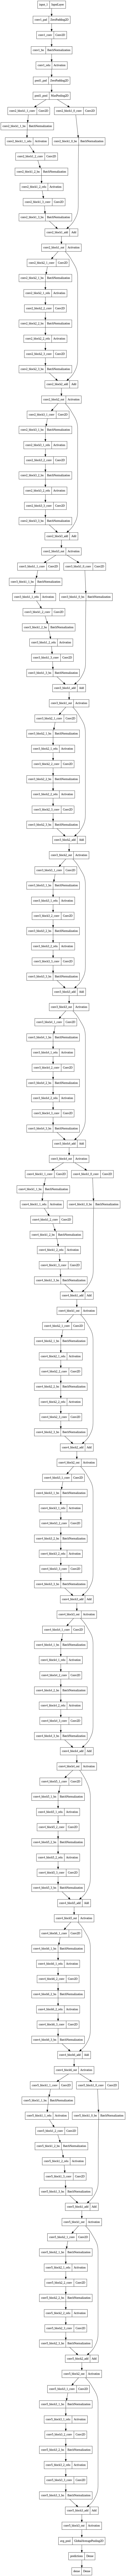

In [ ]:
keras.utils.plot_model(ResNet50_model)

In [ ]:
# Evaluation Best Model
score = ResNet50_model.evaluate(val_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

6/6 [==============================] - 2s 340ms/step - loss: 0.4754 - accuracy: 0.8762
Test loss: 0.4753672182559967
Test accuracy: 0.8761904835700989


## Validation using prediction method

In [ ]:
# Inference
yc1_pred = ResNet50_model.predict(val_dataset)
print('Prediction shape (probability distribution):', yc1_pred.shape)


# Selection of the highest-probability class for each test sample
y1_pred = np.argmax(yc1_pred, axis=1) # second axis= classes
# 734 represent the number of the test samples
print('Prediction shape (argmax):', y1_pred.shape)

12/12 [==============================] - 15s 316ms/step
Prediction shape (probability distribution): (735, 5)
Prediction shape (argmax): (735,)


In [ ]:
# Retrieving the ground truth classes
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

In [ ]:
# Classification report
print('Classification report:')
print(classification_report(y_test, y1_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       127
           1       0.89      0.94      0.91       180
           2       0.83      0.90      0.86       128
           3       0.89      0.89      0.89       140
           4       0.88      0.81      0.85       160

    accuracy                           0.88       735
   macro avg       0.88      0.88      0.88       735
weighted avg       0.88      0.88      0.88       735



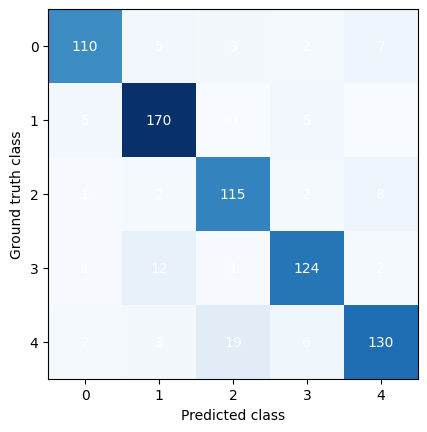

In [ ]:
# Computing the confusion matrix
cm1 = confusion_matrix(y_test, y1_pred)

# Confusion matrix
plt.imshow(cm1, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
for i in range(len(cm1)):
    for j in range(len(cm1[i])):
        plt.text(j, i, str(cm1[i][j]), ha='center', va='center', color='white')

plt.show()

# ResNet152

ResNet152 is residual network architecture with 311 layers and composed of  60.4M Millions parameters. The normalization and ReLU activation are applied before each convolutional layer.

In [ ]:
#using  ResNet152
from tensorflow.keras.applications import ResNet152

In [ ]:
# we set an early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

#we save only the best model
checkpoint_filepath = '/content/gdrive/MyDrive/Project_DeepLearning/ modelli resnet/Model_Resnet152_2_2(64 batch)'
mcp_save1 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')



In [ ]:
ResNet152_model = tf.keras.applications.ResNet152(
    include_top=True,
    weights='imagenet',
    classifier_activation='softmax',
    input_tensor=tf.keras.layers.Input(shape=(224,224,3)))

242900224/242900224 [==============================] - 12s 0us/step


In [ ]:
print(ResNet152_model.summary())

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
 # We freeze the weights of a pre-trained model.Freezing the pre-trained model's weights helps to preserve the already learned features and prevents them from being overwritten or altered during training.
ResNet152_model.trainable = False

#Unfreeze the batch layer
for layer in ResNet152_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [ ]:
# Get the last layer of the model
last_layer = ResNet152_model.layers[-1]

# Modify the last layer to have the desired number of units (ne aveva 1000)
new_last_layer = Dense(num_classes, activation='softmax')(last_layer.output)

# Create a new model with the modified last layer
ResNet152_model= Model(inputs=ResNet152_model.input, outputs=new_last_layer)

In [ ]:
# Explicit input layer
inputss = keras.Input((224,224,3))

x = data_augmentation(inputss)

# Image preprocessing for consistency with the pretrained model x = keras.applications.mobilenet_v2.preprocess_input(x)
# Output of the base model
x = ResNet152_model(x)

# New intermediate fully-connected layer + ReLU

x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(1028, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# New (final) fully-connected layer + SoftMax activation
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

In [ ]:
# Compile the model for training
ResNet152_model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
# We cannot consider 64 batches because the GPU memory is not sufficient.
# Model training
history1 = ResNet152_model.fit(train_dataset,
          epochs=100,
          validation_data=val_dataset,
          callbacks=[callback, mcp_save1]);


Epoch 1/100
46/46 [==============================] - ETA: 0s - loss: 1.6023 - accuracy: 0.3220

46/46 [==============================] - 188s 3s/step - loss: 1.6023 - accuracy: 0.3220 - val_loss: 1.5935 - val_accuracy: 0.3361
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 1.5884 - accuracy: 0.3799

46/46 [==============================] - 121s 3s/step - loss: 1.5884 - accuracy: 0.3799 - val_loss: 1.5747 - val_accuracy: 0.4150
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 1.5719 - accuracy: 0.4078

46/46 [==============================] - 121s 3s/step - loss: 1.5719 - accuracy: 0.4078 - val_loss: 1.5546 - val_accuracy: 0.4585
Epoch 4/100
46/46 [==============================] - ETA: 0s - loss: 1.5502 - accuracy: 0.4317

46/46 [==============================] - 122s 3s/step - loss: 1.5502 - accuracy: 0.4317 - val_loss: 1.5283 - val_accuracy: 0.5102
Epoch 5/100
46/46 [==============================] - ETA: 0s - loss: 1.5206 - accuracy: 0.4951

46/46 [==============================] - 118s 3s/step - loss: 1.5206 - accuracy: 0.4951 - val_loss: 1.4928 - val_accuracy: 0.5701
Epoch 6/100
46/46 [==============================] - ETA: 0s - loss: 1.4812 - accuracy: 0.5676

46/46 [==============================] - 120s 3s/step - loss: 1.4812 - accuracy: 0.5676 - val_loss: 1.4454 - val_accuracy: 0.6218
Epoch 7/100
46/46 [==============================] - ETA: 0s - loss: 1.4334 - accuracy: 0.6300

46/46 [==============================] - 120s 3s/step - loss: 1.4334 - accuracy: 0.6300 - val_loss: 1.3933 - val_accuracy: 0.6803
Epoch 8/100
46/46 [==============================] - ETA: 0s - loss: 1.3828 - accuracy: 0.6886

46/46 [==============================] - 122s 3s/step - loss: 1.3828 - accuracy: 0.6886 - val_loss: 1.3409 - val_accuracy: 0.7007
Epoch 9/100
46/46 [==============================] - ETA: 0s - loss: 1.3261 - accuracy: 0.7387

46/46 [==============================] - 120s 3s/step - loss: 1.3261 - accuracy: 0.7387 - val_loss: 1.2904 - val_accuracy: 0.7306
Epoch 10/100
46/46 [==============================] - ETA: 0s - loss: 1.2651 - accuracy: 0.7796

46/46 [==============================] - 120s 3s/step - loss: 1.2651 - accuracy: 0.7796 - val_loss: 1.2381 - val_accuracy: 0.7619
Epoch 11/100
46/46 [==============================] - ETA: 0s - loss: 1.2049 - accuracy: 0.8126

46/46 [==============================] - 120s 3s/step - loss: 1.2049 - accuracy: 0.8126 - val_loss: 1.1845 - val_accuracy: 0.7850
Epoch 12/100
46/46 [==============================] - ETA: 0s - loss: 1.1399 - accuracy: 0.8416

46/46 [==============================] - 120s 3s/step - loss: 1.1399 - accuracy: 0.8416 - val_loss: 1.1311 - val_accuracy: 0.8041
Epoch 13/100
46/46 [==============================] - ETA: 0s - loss: 1.0813 - accuracy: 0.8668

46/46 [==============================] - 126s 3s/step - loss: 1.0813 - accuracy: 0.8668 - val_loss: 1.0794 - val_accuracy: 0.8218
Epoch 14/100
46/46 [==============================] - ETA: 0s - loss: 1.0218 - accuracy: 0.8835

46/46 [==============================] - 122s 3s/step - loss: 1.0218 - accuracy: 0.8835 - val_loss: 1.0296 - val_accuracy: 0.8231
Epoch 15/100
46/46 [==============================] - ETA: 0s - loss: 0.9599 - accuracy: 0.8951

46/46 [==============================] - 120s 3s/step - loss: 0.9599 - accuracy: 0.8951 - val_loss: 0.9790 - val_accuracy: 0.8408
Epoch 16/100
46/46 [==============================] - ETA: 0s - loss: 0.9067 - accuracy: 0.9039

46/46 [==============================] - 120s 3s/step - loss: 0.9067 - accuracy: 0.9039 - val_loss: 0.9358 - val_accuracy: 0.8476
Epoch 17/100
46/46 [==============================] - ETA: 0s - loss: 0.8473 - accuracy: 0.9165

46/46 [==============================] - 120s 3s/step - loss: 0.8473 - accuracy: 0.9165 - val_loss: 0.8944 - val_accuracy: 0.8531
Epoch 18/100
46/46 [==============================] - ETA: 0s - loss: 0.7983 - accuracy: 0.9216

46/46 [==============================] - 121s 3s/step - loss: 0.7983 - accuracy: 0.9216 - val_loss: 0.8599 - val_accuracy: 0.8517
Epoch 19/100
46/46 [==============================] - ETA: 0s - loss: 0.7477 - accuracy: 0.9295

46/46 [==============================] - 122s 3s/step - loss: 0.7477 - accuracy: 0.9295 - val_loss: 0.8185 - val_accuracy: 0.8544
Epoch 20/100
46/46 [==============================] - ETA: 0s - loss: 0.7010 - accuracy: 0.9373

46/46 [==============================] - 125s 3s/step - loss: 0.7010 - accuracy: 0.9373 - val_loss: 0.7787 - val_accuracy: 0.8680
Epoch 21/100
46/46 [==============================] - ETA: 0s - loss: 0.6611 - accuracy: 0.9387

46/46 [==============================] - 123s 3s/step - loss: 0.6611 - accuracy: 0.9387 - val_loss: 0.7465 - val_accuracy: 0.8639
Epoch 22/100
46/46 [==============================] - ETA: 0s - loss: 0.6144 - accuracy: 0.9462

46/46 [==============================] - 121s 3s/step - loss: 0.6144 - accuracy: 0.9462 - val_loss: 0.7196 - val_accuracy: 0.8612
Epoch 23/100
46/46 [==============================] - ETA: 0s - loss: 0.5753 - accuracy: 0.9475

46/46 [==============================] - 122s 3s/step - loss: 0.5753 - accuracy: 0.9475 - val_loss: 0.6861 - val_accuracy: 0.8680
Epoch 24/100
46/46 [==============================] - ETA: 0s - loss: 0.5400 - accuracy: 0.9526

46/46 [==============================] - 121s 3s/step - loss: 0.5400 - accuracy: 0.9526 - val_loss: 0.6651 - val_accuracy: 0.8721
Epoch 25/100
46/46 [==============================] - ETA: 0s - loss: 0.4964 - accuracy: 0.9601

46/46 [==============================] - 122s 3s/step - loss: 0.4964 - accuracy: 0.9601 - val_loss: 0.6339 - val_accuracy: 0.8789
Epoch 26/100
46/46 [==============================] - ETA: 0s - loss: 0.4662 - accuracy: 0.9622

46/46 [==============================] - 120s 3s/step - loss: 0.4662 - accuracy: 0.9622 - val_loss: 0.6079 - val_accuracy: 0.8789
Epoch 27/100
46/46 [==============================] - ETA: 0s - loss: 0.4293 - accuracy: 0.9670

46/46 [==============================] - 120s 3s/step - loss: 0.4293 - accuracy: 0.9670 - val_loss: 0.5872 - val_accuracy: 0.8844
Epoch 28/100
46/46 [==============================] - ETA: 0s - loss: 0.3977 - accuracy: 0.9704

46/46 [==============================] - 120s 3s/step - loss: 0.3977 - accuracy: 0.9704 - val_loss: 0.5721 - val_accuracy: 0.8857
Epoch 29/100
46/46 [==============================] - ETA: 0s - loss: 0.3804 - accuracy: 0.9687

46/46 [==============================] - 121s 3s/step - loss: 0.3804 - accuracy: 0.9687 - val_loss: 0.5532 - val_accuracy: 0.8776
Epoch 30/100
46/46 [==============================] - ETA: 0s - loss: 0.3539 - accuracy: 0.9707

46/46 [==============================] - 123s 3s/step - loss: 0.3539 - accuracy: 0.9707 - val_loss: 0.5346 - val_accuracy: 0.8844
Epoch 31/100
46/46 [==============================] - ETA: 0s - loss: 0.3234 - accuracy: 0.9772

46/46 [==============================] - 124s 3s/step - loss: 0.3234 - accuracy: 0.9772 - val_loss: 0.5134 - val_accuracy: 0.8857
Epoch 32/100
46/46 [==============================] - ETA: 0s - loss: 0.3074 - accuracy: 0.9761

46/46 [==============================] - 121s 3s/step - loss: 0.3074 - accuracy: 0.9761 - val_loss: 0.5032 - val_accuracy: 0.8816
Epoch 33/100
46/46 [==============================] - ETA: 0s - loss: 0.2832 - accuracy: 0.9792

46/46 [==============================] - 122s 3s/step - loss: 0.2832 - accuracy: 0.9792 - val_loss: 0.4937 - val_accuracy: 0.8776
Epoch 34/100
46/46 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9830

46/46 [==============================] - 121s 3s/step - loss: 0.2556 - accuracy: 0.9830 - val_loss: 0.4857 - val_accuracy: 0.8789
Epoch 35/100
46/46 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9853

46/46 [==============================] - 122s 3s/step - loss: 0.2389 - accuracy: 0.9853 - val_loss: 0.4763 - val_accuracy: 0.8762
Epoch 36/100
46/46 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.9823

46/46 [==============================] - 121s 3s/step - loss: 0.2316 - accuracy: 0.9823 - val_loss: 0.4619 - val_accuracy: 0.8871
Epoch 37/100
46/46 [==============================] - ETA: 0s - loss: 0.2159 - accuracy: 0.9830

46/46 [==============================] - 125s 3s/step - loss: 0.2159 - accuracy: 0.9830 - val_loss: 0.4563 - val_accuracy: 0.8789
Epoch 38/100
46/46 [==============================] - 56s 1s/step - loss: 0.1929 - accuracy: 0.9877 - val_loss: 0.4595 - val_accuracy: 0.8789
Epoch 39/100
46/46 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9898

46/46 [==============================] - 119s 3s/step - loss: 0.1785 - accuracy: 0.9898 - val_loss: 0.4479 - val_accuracy: 0.8844
Epoch 40/100
46/46 [==============================] - ETA: 0s - loss: 0.1649 - accuracy: 0.9908

46/46 [==============================] - 121s 3s/step - loss: 0.1649 - accuracy: 0.9908 - val_loss: 0.4407 - val_accuracy: 0.8871
Epoch 41/100
46/46 [==============================] - ETA: 0s - loss: 0.1632 - accuracy: 0.9877

46/46 [==============================] - 122s 3s/step - loss: 0.1632 - accuracy: 0.9877 - val_loss: 0.4343 - val_accuracy: 0.8871
Epoch 42/100
46/46 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9894

46/46 [==============================] - 120s 3s/step - loss: 0.1504 - accuracy: 0.9894 - val_loss: 0.4265 - val_accuracy: 0.8912
Epoch 43/100
46/46 [==============================] - 56s 1s/step - loss: 0.1381 - accuracy: 0.9891 - val_loss: 0.4289 - val_accuracy: 0.8857
Epoch 44/100
46/46 [==============================] - 61s 1s/step - loss: 0.1266 - accuracy: 0.9915 - val_loss: 0.4311 - val_accuracy: 0.8898
Epoch 45/100
46/46 [==============================] - 56s 1s/step - loss: 0.1161 - accuracy: 0.9925 - val_loss: 0.4316 - val_accuracy: 0.8898
Epoch 46/100
46/46 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9935

46/46 [==============================] - 120s 3s/step - loss: 0.1081 - accuracy: 0.9935 - val_loss: 0.4183 - val_accuracy: 0.8939
Epoch 47/100
46/46 [==============================] - 55s 1s/step - loss: 0.1022 - accuracy: 0.9932 - val_loss: 0.4200 - val_accuracy: 0.8844
Epoch 48/100
46/46 [==============================] - 56s 1s/step - loss: 0.0935 - accuracy: 0.9952 - val_loss: 0.4221 - val_accuracy: 0.8898
Epoch 49/100
46/46 [==============================] - 55s 1s/step - loss: 0.0868 - accuracy: 0.9949 - val_loss: 0.4265 - val_accuracy: 0.8844
Epoch 50/100
46/46 [==============================] - 55s 1s/step - loss: 0.0804 - accuracy: 0.9939 - val_loss: 0.4387 - val_accuracy: 0.8830
Epoch 51/100
46/46 [==============================] - 55s 1s/step - loss: 0.0766 - accuracy: 0.9952 - val_loss: 0.4368 - val_accuracy: 0.8857
Epoch 52/100
46/46 [==============================] - 56s 1s/step - loss: 0.0689 - accuracy: 0.9963 - val_loss: 0.4383 - val_accuracy: 0.8871
Epoch 53/100
46/46

In [ ]:
# To load the best model
ResNet152_model.load_weights(checkpoint_filepath)

In [ ]:
# Evaluation Best Model
score = ResNet152_model.evaluate(val_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 5s 399ms/step - loss: 0.4321 - accuracy: 0.8912
Test loss: 0.43214285373687744
Test accuracy: 0.8911564350128174


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.660585 to fit



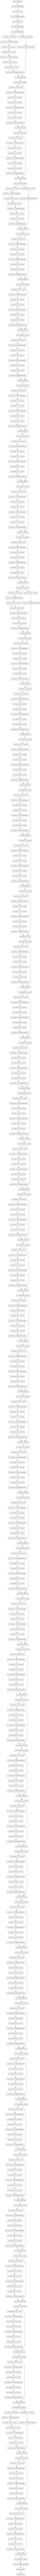

In [ ]:
keras.utils.plot_model(ResNet152_model)

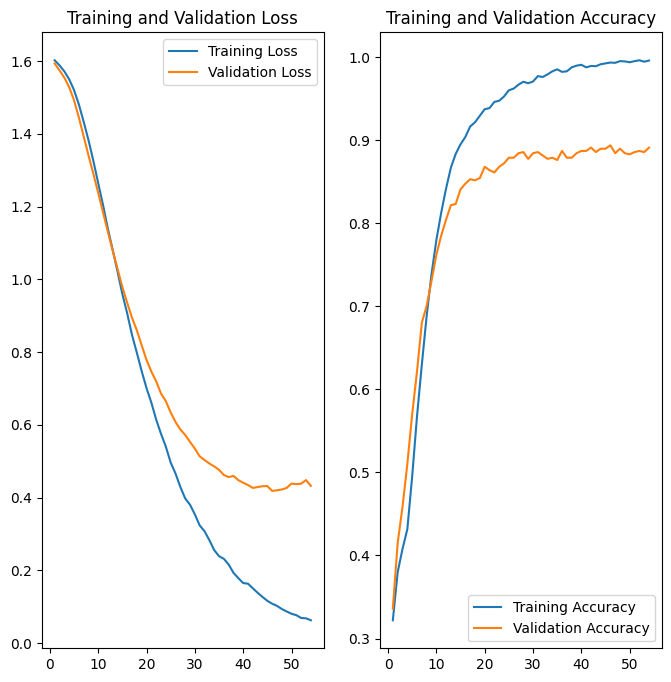

In [ ]:
# Visualization of the learning curves
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

num_epochs = len(history1.epoch)
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Inference
yc1_pred = ResNet152_model.predict(val_dataset)
print('Prediction shape (probability distribution):', yc1_pred.shape)


# Selection of the highest-probability class for each test sample
y1_pred = np.argmax(yc1_pred, axis=1) # second axis= classes
# 734 represent the number of the test samples
print('Prediction shape (argmax):', y1_pred.shape)

12/12 [==============================] - 9s 398ms/step
Prediction shape (probability distribution): (735, 5)
Prediction shape (argmax): (735,)


In [ ]:
# Retrieving the ground truth classes
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# Classification report
print('Classification report:')
print(classification_report(y_test, y1_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       127
           1       0.92      0.97      0.94       180
           2       0.80      0.84      0.82       128
           3       0.95      0.94      0.94       140
           4       0.84      0.84      0.84       160

    accuracy                           0.89       735
   macro avg       0.89      0.89      0.89       735
weighted avg       0.90      0.89      0.89       735



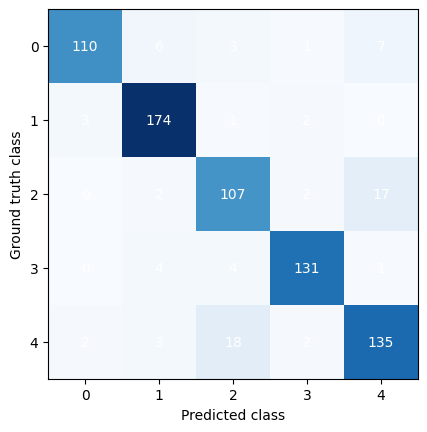

In [ ]:
# Computing the confusion matrix
cm2 = confusion_matrix(y_test, y1_pred)

# Confusion matrix
plt.imshow(cm2, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
for i in range(len(cm2)):
    for j in range(len(cm2[i])):
        plt.text(j, i, str(cm2[i][j]), ha='center', va='center', color='white')

plt.show()